# Heat Transfer (L3)
**Mattia Sotgia<sup>1</sup>, Francesco Polleri <sup>1</sup>** \
_<sup>1</sup>Dipartimento di Fisica, Università degli studi di Genova_


In [1]:
import numpy as np
import matplotlib.pyplot as plt
from dataclasses import dataclass

from data_util import Data

import ROOT
from iminuit import Minuit
from iminuit.cost import LeastSquares
import mplhep as hep

from scipy import fft

plt.style.use(['std-colors',hep.style.ATLAS])

Welcome to JupyROOT 6.24/02


## Analisi dati
Abbiamo acquisito 1200 punti (con frequenza di 10Hz) divisi in 4 dataset, divsi come
 - 2 dataaset (`20230321_1_1s` e `20230321_2_1s`) con impulso iniziale di ~1 s
 - 1 dataset con $\Delta_\text{pulse}$ = 0.5 e 1 dataset con 1.5 s

La `dataclass` Data contiene i dati necessari e anche una visualizzazione rapida, accessibile come `Data.prelim_plot()`, anche potendo esplorare limiti bassi e alti nei tempi. 

Importo i dati in un formato comodo per la trasformzione successiva. 

In [2]:
D1 = Data(np.loadtxt('data/20230321_1_1s.lvm', skiprows=23, unpack=True), 1)
D2 = Data(np.loadtxt('data/20230321_2_1s.lvm', skiprows=23, unpack=True), 1)
D3 = Data(np.loadtxt('data/20230321_3_1s.lvm', skiprows=23, unpack=True), 1)
D4 = Data(np.loadtxt('data/20230321_4_0.5s.lvm', skiprows=23, unpack=True), 0.5)
D5 = Data(np.loadtxt('data/20230321_5_1.5s.lvm', skiprows=23, unpack=True), 1.5)

Possiamo così rapidamente analizzare i valori ottenuti (per esempio osservo subito che la temperatura del PT100 risulta invariante rispetto al tempo)

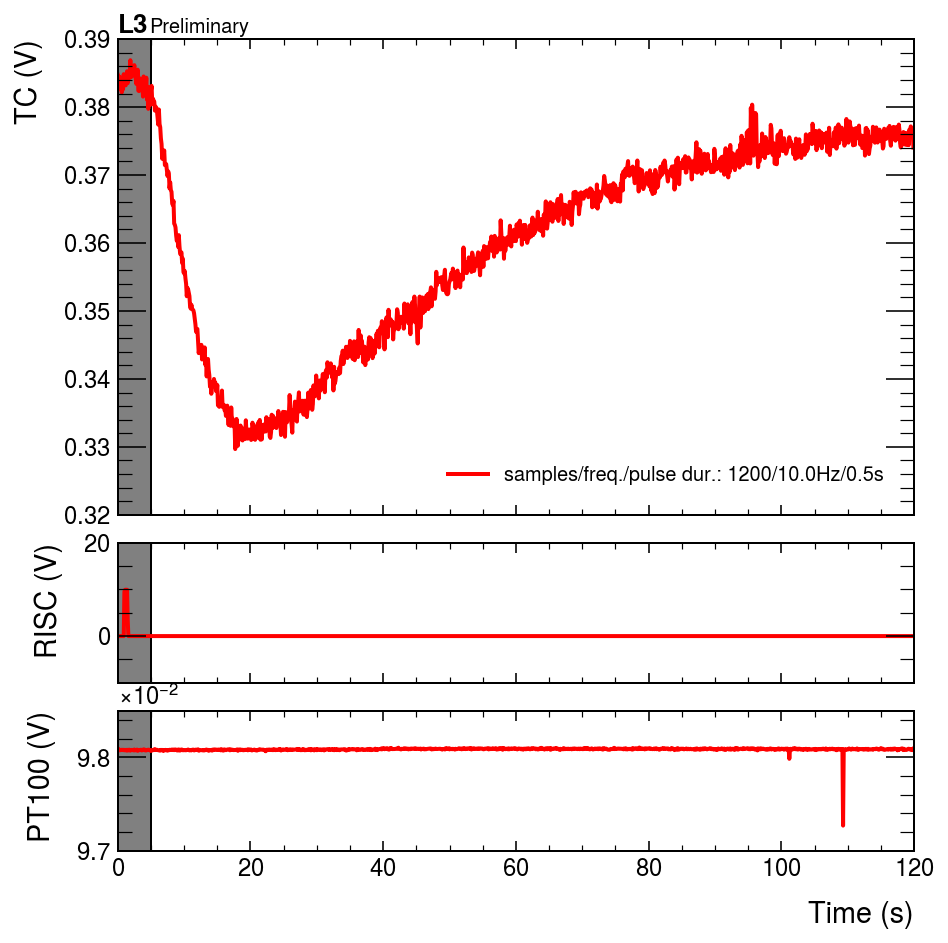

In [3]:
D4.prelim_plot(0,5)

Data l'equazione per una sbarretta semi-infinita (correggo poi dopo con una restrizione del dominio), $$\frac{\partial T}{\partial t} = k \nabla T,$$ possiamo ottenere soluzione del tipo $$T(x,t) = \frac{C}{\sqrt{Dt}} \exp(-\frac{x^2}{4Dt}) + T_0.$$

In [4]:
@dataclass
class AnalysisData():
    time: np.ndarray
    T_TC: np.ndarray
    T_PT100: np.ndarray
    error_TC: float
    
    def __init__(self, time, T_TC, T_PT100, error_TC, name):
        self.time = time
        self.T_TC = T_TC
        self.T_PT100 = T_PT100
        self.error_TC = error_TC
        self.name = name


class Analysis():
    bar_lenght: float = 63e-3
    TC_position: float = 23e-3
    TC_conversion = 1/41e-6
    error: float = 0
    data = None
    
    def __init__(self, data: Data, cut: float = 5):
        self.gain = 2000
        
        def PT100_temp(data):
            i_pt100 = 1/1100 ###> R_eq \simeq 1k + 0.1k
            return 14e-4 * (data.PT100 / i_pt100)**2 + 2.2959 * data.PT100 / i_pt100 + 29.77
    
        def TC_temp(data):
            return (data.TC / self.gain) * self.TC_conversion
        
        T_TC = TC_temp(data)
        T_PT100 = PT100_temp(data)
        
        self.offset = np.mean(
            np.extract(
                data.time < cut,
                T_TC
            )
        )
        error = np.std(
            np.extract(
                data.time < cut,
                T_TC
            )
        )
        
        T_TC = - (T_TC - self.offset) ##> Correzione: senso fisico mancante
        
        self.data = AnalysisData(data.time, T_TC, T_PT100, error, data.name)

    
    def filter(self, min_time: float = 0, max_time: float = 120):
        data = self.data
        if min_time < np.min(data.time):
            raise ValueError(f'{min_time = } is out of bounds')
        if max_time > np.max(data.time):
            raise ValueError(f'{max_time = } is out of bounds')
        
        low_index = np.where(data.time == min_time)[0][0]
        hi_index = np.where(data.time == max_time)[0][0]
        
        self.data = AnalysisData(
            data.time[low_index:hi_index],
            data.T_TC[low_index:hi_index],
            data.T_PT100[low_index:hi_index],
            data.error_TC,
            data.name
        )
        
        return self
    

    def plot_linearized(self):
        
        inverted_time = 1/self.data.time
        linearized_temperature = np.log(self.data.T_TC * np.sqrt(self.data.time))
        signal_error = 1/self.data.T_TC * self.data.error_TC
        
        plt.errorbar(inverted_time, linearized_temperature, signal_error, None, 'ko', 
                     markersize=1.5, label=f'(TC) {self.data.name}')
        plt.xlabel(r'$1/t$ (s$^{-1}$)')
        plt.ylabel(r'$\log(\sqrt{t}\cdot T_\mathrm{TC})$')
        
        return inverted_time, linearized_temperature, signal_error
    
    def linearized_model_fit(self, coefficient: float=1, offset: float=0):
        
        def model(x, α, β):
            return x * α + β
        
        x, y, signal_error = self.plot_linearized()
        
        LSmodel = LeastSquares(x, y, signal_error, model)
        M1 = Minuit(LSmodel, α=coefficient, β=offset)
        M1.migrad()
        plt.plot(x, model(x, *M1.values))
        D = - self.TC_position**2 / (4 * M1.values['α'])
        err_D = self.TC_position**2 / (4 * M1.values['α']**2) * M1.errors['α']
        
        return D, err_D, M1
    
    def plot_temp(self, which: str='TC'):

        data = self.data
        temp = None
        if which == 'TC': 
            temp = data.T_TC
        elif which == 'PT100': 
            temp = data.T_PT100
        else: raise Exception('which in [TC, PT100]')
        
        plt.plot(data.time, temp, label=f'({which}) {data.name}')
        plt.xlabel('Time (s)')
        plt.ylabel('Temperature (K)')
    
    def full_model_fit(self, fit_limits = (5, 30), D: float = 1e-6, C: float = 50, offset: float = 0):
        
        def model(t, D, C, offset):
            return C/np.sqrt(D * t) * np.exp(- self.TC_position**2 / (4 * D * t)) + offset
        
        
        time = self.data.time
        T = self.data.T_TC
        σ_T = self.data.error_TC
        
        plt.errorbar(time, T, σ_T, None, 'ko', 
                     markersize=1.5, label=f'(TC) {self.data.name}')
        plt.xlabel('Time (s)')
        plt.ylabel('Temperature (K)')
        
        filtered = self.filter(*fit_limits)
        t_fit = filtered.data.time
        T_fit = filtered.data.T_TC
        
        LSmodel = LeastSquares(t_fit, T_fit, σ_T, model)
        M1 = Minuit(LSmodel, D=D, C=C, offset=offset)
        M1.migrad()
        plt.plot(t_fit, model(t_fit, *M1.values), zorder=100)
        
        # print(M1)
        
        return M1.values['D'], M1.errors['D'], M1
        

### Linearizzazione

Posso osservare che graficando idealmente $$\log{\sqrt{t}T_\text{TC}} = \log\left(\frac{C}{\sqrt{D}} \exp(-\frac{x^2}{4Dt})\right)$$ contro $1/t$, allora diventa $f(1/t) = -\frac{x_0^2}{4Dt}$, che risulta essere più comoda da trattare

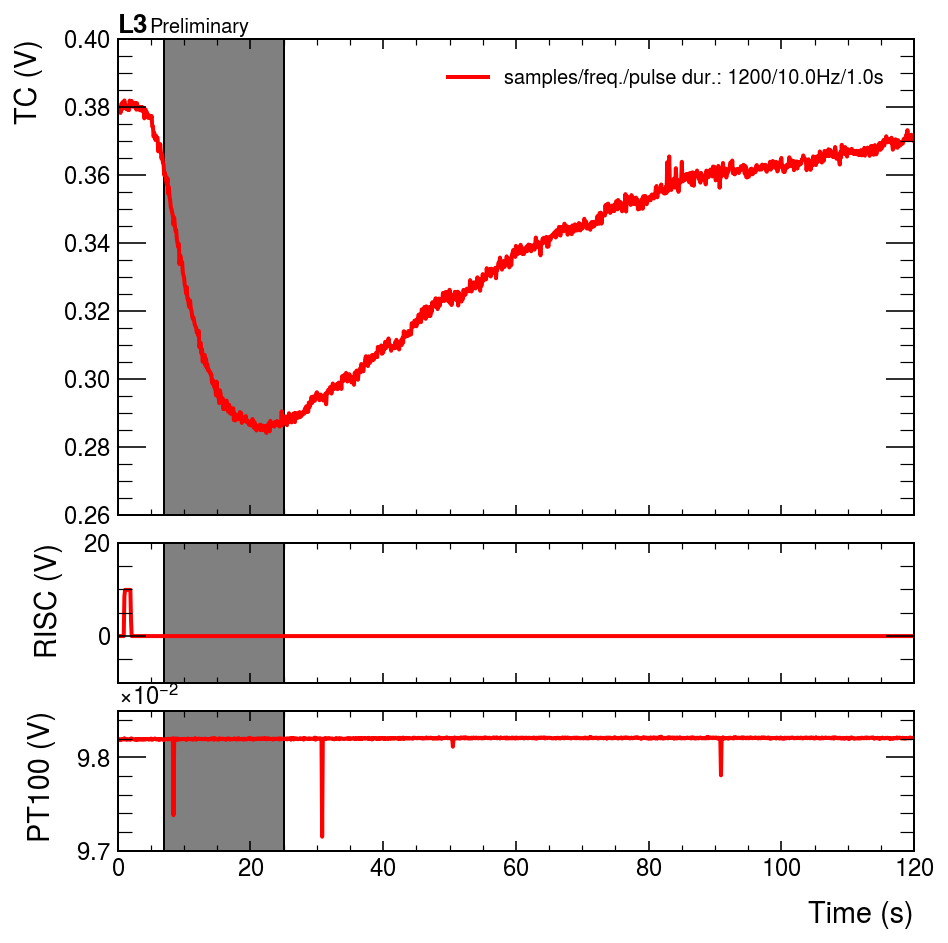

In [5]:
low, up = 7, 25
D1.prelim_plot(low,up)

D = 7.221(29)e-06 m^2/s 	for D1 (samples/freq./pulse dur.: 1200/10.0Hz/1.0s) 	 (p-value: 0.0, χ2/df = (1817.8476961834785, 178.0))
D = 7.362(34)e-06 m^2/s 	for D2 (samples/freq./pulse dur.: 1200/10.0Hz/1.0s) 	 (p-value: 0.0, χ2/df = (1798.307217493346, 178.0))
D = 6.86(4)e-06 m^2/s 	for D3 (samples/freq./pulse dur.: 240/2.0Hz/1.0s) 	 (p-value: 0.0, χ2/df = (1053.1372633886742, 34.0))
D = 7.38(6)e-06 m^2/s 	for D4 (samples/freq./pulse dur.: 1200/10.0Hz/0.5s) 	 (p-value: 0.0, χ2/df = (587.720727364311, 178.0))
D = 6.944(21)e-06 m^2/s 	for D5 (samples/freq./pulse dur.: 1200/10.0Hz/1.5s) 	 (p-value: 0.0, χ2/df = (4222.008268631143, 178.0))


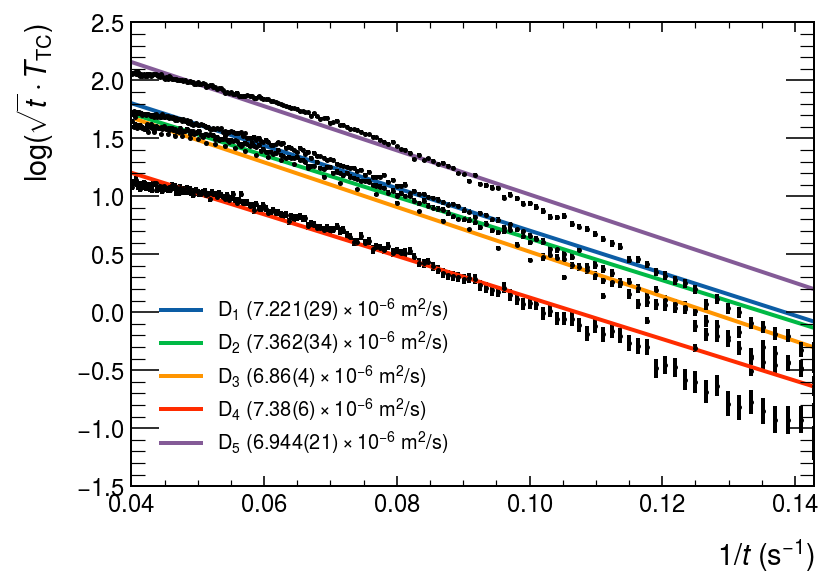

In [6]:
from scipy import stats
from uncertainties import ufloat

values = np.array([D for D in [D1, D2, D3, D4, D5]], dtype=str)

for i, D in enumerate([D1, D2, D3, D4, D5]):
    value, error, M = Analysis(D).filter(low, up).linearized_model_fit(-30, 2)
    print(f'D = {ufloat(value, error):.uS} m^2/s \tfor D{i+1} ({D.name}) \t (p-value: {1 - stats.chi2.cdf(M.fmin.fval, M.ndof)}, χ2/df = {M.fval, M.ndof})')
    values[i] = f'${ufloat(value, error):.uSL}$ m$^2$/s'

plt.xlim(1/up, 1/low) # adjust th xlim (broken?)
plt.legend([f'D$_{i+1}$ ({values[i]})' for i, D in enumerate([D1, D2, D3, D4, D5])])

D = 1.097(5)e-05 m^2/s 	for D1 (samples/freq./pulse dur.: 1200/10.0Hz/1.0s) 	 (p-value: 0.0, χ2/df = 1064.279/237.0)
D = 1.141(6)e-05 m^2/s 	for D2 (samples/freq./pulse dur.: 1200/10.0Hz/1.0s) 	 (p-value: 0.0, χ2/df = 908.003/237.0)
D = 1.003(8)e-05 m^2/s 	for D3 (samples/freq./pulse dur.: 240/2.0Hz/1.0s) 	 (p-value: 0.0, χ2/df = 525.507/45.0)
D = 1.160(10)e-05 m^2/s 	for D4 (samples/freq./pulse dur.: 1200/10.0Hz/0.5s) 	 (p-value: 2.4424906541753444e-15, χ2/df = 449.586/237.0)
D = 1.2036(26)e-05 m^2/s 	for D5 (samples/freq./pulse dur.: 1200/10.0Hz/1.5s) 	 (p-value: 0.0, χ2/df = 4228.252/287.0)


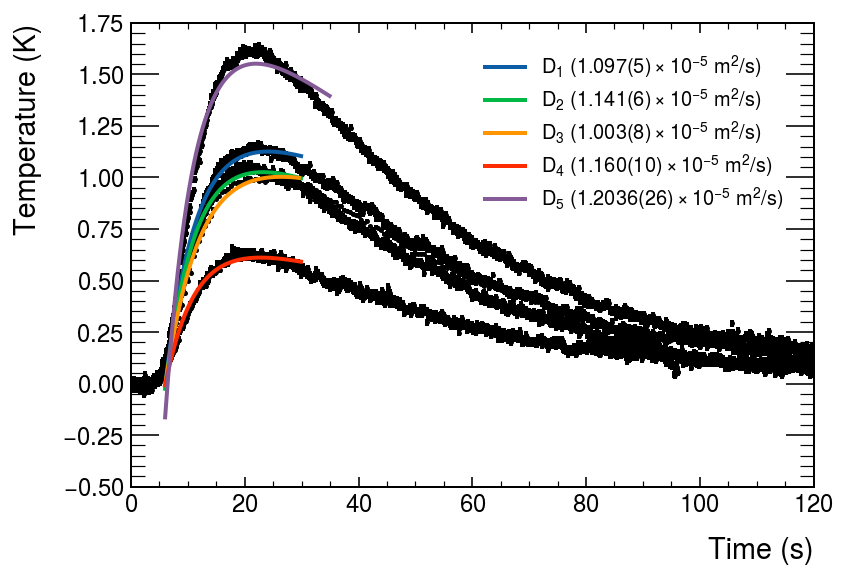

In [7]:
fit_limits = [
    (6,30), #> D1
    (6,30), #> D2
    (6,30), #> D3
    (6,30), #> D4
    (6,35), #> D5
]

for i, D in enumerate([D1, D2, D3, D4, D5]):
    value, error, M = Analysis(D).full_model_fit(fit_limits=fit_limits[i])
    print(f'D = {ufloat(value, error):.uS} m^2/s \tfor D{i+1} ({D.name}) \t (p-value: {1 - stats.chi2.cdf(M.fmin.fval, M.ndof)}, χ2/df = {M.fval:.3f}/{M.ndof})')
    values[i] = f'${ufloat(value, error):.uSL}$ m$^2$/s'

plt.legend([f'D$_{i+1}$ ({values[i]})' for i, D in enumerate([D1, D2, D3, D4, D5])])

In questo ultimo caso l'andamento lineare lo otteniamo invece restringendo ancora la finetra, passando infatti a [5, 17] s l'andamento può risultare lineare.

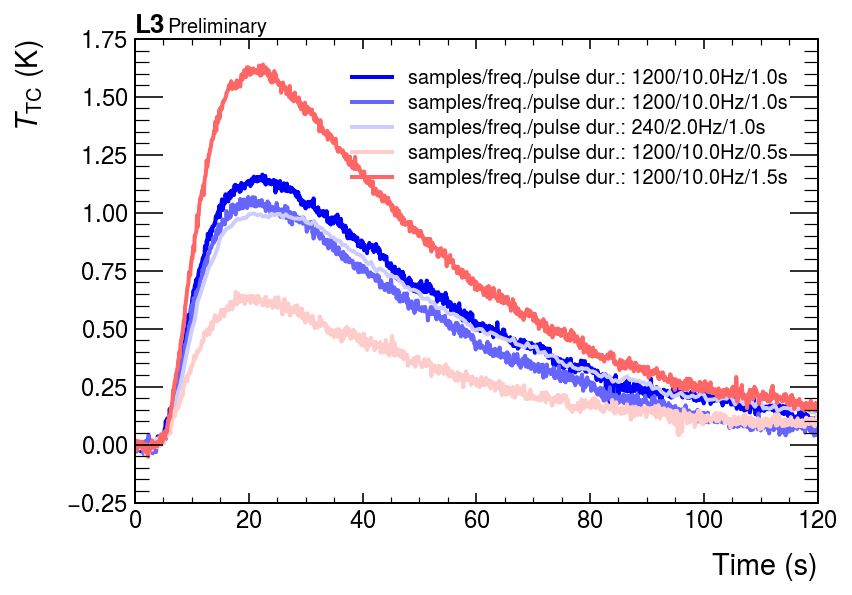

In [8]:
colors = plt.cm.bwr
for i, D in enumerate([D1, D2, D3, D4, D5]):
    plt.plot(D.time[1:], Analysis(D).data.T_TC[1:], label=D.name, color=colors(i/5))
plt.xlabel('Time (s)')
plt.ylabel('$T_\mathrm{TC}$ (K)')
hep.label.exp_text('L3','Preliminary')
plt.legend()

In [9]:
class Simulation:
    max_time: float = 120
    time_samples: int = 1200
    bar_lenght: float = 63e-3
    lenght_samples: int
    
    delta_lenght: float = 0
    delta_time: float = 0
    
    time_array: np.ndarray
    TC_data_array: np.ndarray
    
    kappa: float = 40
    eta: float
    TC_position: float = 23e-3
    TC_position_index: int
    
    def __init__(self, time, time_samples=1_000_000_000, bar_samples=100, kappa=None, bar_lenght=63e-3):
        if kappa is not None: self.kappa = kappa
        self.time = time
        self.time_samples = time_samples
        self.lenght_samples = bar_samples
        self.delta_time = time / time_samples
        self.delta_lenght = self.bar_lenght / bar_samples
        
        
        self.eta = self.kappa * self.delta_time / self.delta_lenght**2
        if self.eta > 0.5: raise Warning(f'eta {self.eta}>0.5, simulation may diverge')